In [95]:
#!/usr/bin/env python
import pandas as pd
import numpy as np 

# download the data from the Vanderbilt University Department of Biostatistics servers
titanic_df = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv')

# take a peek at the data
print(titanic_df.head())


   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

     age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.00      0      0   24160  211.3375       B5        S    2    NaN   
1   0.92      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.00      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.00      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.00      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St Louis, MO  


<H1>Data Exploration</H1>

In [96]:
# feature data types
titanic_df.dtypes


pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [97]:
# summary of quantitative data
titanic_df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [98]:
# count missing data
titanic_missing_count = titanic_df.isnull().sum().sort_values(ascending=False)
pd.DataFrame({'Percent Missing':titanic_missing_count/len(titanic_df)})


,Percent Missing
body,0.907563
cabin,0.774637
boat,0.628724
home.dest,0.430863
age,0.200917
embarked,0.001528
fare,0.000764
ticket,0.000000
parch,0.000000
sibsp,0.000000


<H1>Data Preparation</H1>

In [99]:

# create title field and get extract title name
titanic_df['title'] = [ln.split()[1] for ln in titanic_df['name'].values]
titanic_df['title'].value_counts()
titanic_df['title'] = [title if title in ['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Dr.', 'Rev.'] else 'Unknown'
                       for title in titanic_df['title'].values ]

# strip first letter from cabin number if there
titanic_df['cabin'] = titanic_df['cabin'].replace(np.NaN, 'U') 
titanic_df['cabin'] = [ln[0] for ln in titanic_df['cabin'].values]
titanic_df['cabin'] = titanic_df['cabin'].replace('U', 'Unknown') 
print(set(titanic_df['embarked']))

# create isfemale field and use numerical values
titanic_df['isfemale'] = np.where(titanic_df['sex'] == 'female', 1, 0)

# drop features not needed for model 
titanic_df = titanic_df[[f for f in list(titanic_df) if f not in ['sex', 'name', 'boat','body', 'ticket', 'home.dest']]]

# make pclass actual categorical column
titanic_df['pclass'] = np.where(titanic_df['pclass'] == 1, 'First', 
                                np.where(titanic_df['pclass'] == 2, 'Second', 'Third'))


titanic_df['embarked'] = titanic_df['embarked'].replace(np.NaN, 'Unknown') 


print(titanic_df.head(10))

set([nan, 'Q', 'S', 'C'])
  pclass  survived    age  sibsp  parch      fare    cabin embarked    title  \
0  First         1  29.00      0      0  211.3375        B        S    Miss.   
1  First         1   0.92      1      2  151.5500        C        S  Master.   
2  First         0   2.00      1      2  151.5500        C        S    Miss.   
3  First         0  30.00      1      2  151.5500        C        S      Mr.   
4  First         0  25.00      1      2  151.5500        C        S     Mrs.   
5  First         1  48.00      0      0   26.5500        E        S      Mr.   
6  First         1  63.00      1      0   77.9583        D        S    Miss.   
7  First         0  39.00      0      0    0.0000        A        S      Mr.   
8  First         1  53.00      2      0   51.4792        C        S     Mrs.   
9  First         0  71.00      0      0   49.5042  Unknown        C      Mr.   

   isfemale  
0         1  
1         0  
2         1  
3         0  
4         1  
5        

<H1>Modeling with Logistic Regression</H1>

In [100]:
# get average survival rate to compare to prediction values
average_survival_rate = np.mean(titanic_df['survived']) * 100
print('Average probability of surviving Titanic trip: %.2f percent' % average_survival_rate)


Average probability of surviving Titanic trip: 38.20 percent


In [101]:
def prepare_data_for_model(raw_dataframe):
    # dummy all categorical fields 
    dataframe_dummy = pd.get_dummies(raw_dataframe)
    # remove the nan colums in dataframe as most are outcome variable and we can't use them
    dataframe_dummy = dataframe_dummy.dropna() 
    return (dataframe_dummy)
 

In [102]:
titanic_ready_df = prepare_data_for_model(titanic_df)
from sklearn.cross_validation import cross_val_score, cross_val_predict
 
features = [feat for feat in list(titanic_ready_df) if feat != 'survived']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(titanic_ready_df.loc[:, titanic_ready_df.columns != 'survived'], titanic_ready_df[['survived']], test_size=0.5, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn import metrics


# logistic regression modeling
lr_model = LogisticRegression()

# fit model (train it with training portion)
lr_model.fit(X_train, np.ravel(y_train))

# predict on test portion
y_pred = lr_model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}%'.format(lr_model.score(X_test, y_test)*100))


Accuracy of logistic regression classifier on test set: 79.35%


<H1>Predict using Fictional Passenger</H1>

In [103]:
# Create your own passenger
x_predict_pclass = 'Third' # First, Second, Third
x_predict_is_female=1 # 0-1
x_predict_age=10 # 0-100
x_predict_sibsp=3 #  (0-8)
x_predict_parch = 0 #  (0-9)
x_predict_fare = 200 #  (0-500)
x_predict_cabin = 'A' # 'A', 'C', 'B', 'E', 'D', 'G', 'F', 'T', 'Z' 
x_predict_embarked = 'Q' #  'Q', 'S', 'C' # Cherbourg Queenstown Southampton
x_predict_title = 'Mrs.' # ['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Dr.', 'Rev.', Unknown]
 

In [104]:
# make a copy of the original data set in order to create dummy categories that are the same as seen on 
# original data
titanic_df_tmp = titanic_df.copy()
# add new row to titanic df
titanic_df_tmp = titanic_df_tmp[['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked', 'title', 'isfemale', 'survived']] 

titanic_fictional_df = pd.DataFrame([[x_predict_pclass, 
                                     x_predict_age,
                                     x_predict_sibsp,
                                     x_predict_parch,
                                     x_predict_fare,
                                     x_predict_cabin,
                                     x_predict_embarked,
                                     x_predict_title,
                                     x_predict_is_female,
                                     0]], columns = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked', 'title', 'isfemale', 'survived']) 


In [105]:
# titanic_df_tmp.append(titanic_fictional_df)
titanic_df_tmp = pd.concat([titanic_fictional_df, titanic_df_tmp], ignore_index=True)
# titanic_df_tmp = pd.get_dummies(titanic_df_tmp)
titanic_df_tmp = prepare_data_for_model(titanic_df_tmp)

Y_pred = lr_model.predict_proba(titanic_df_tmp[features].head(1))
probability_of_surviving_fictional_character = Y_pred[0][1] * 100
print('Probability of surviving Titanic voyage: %.2f percent' % probability_of_surviving_fictional_character)



Probability of surviving Titanic voyage: 88.03 percent


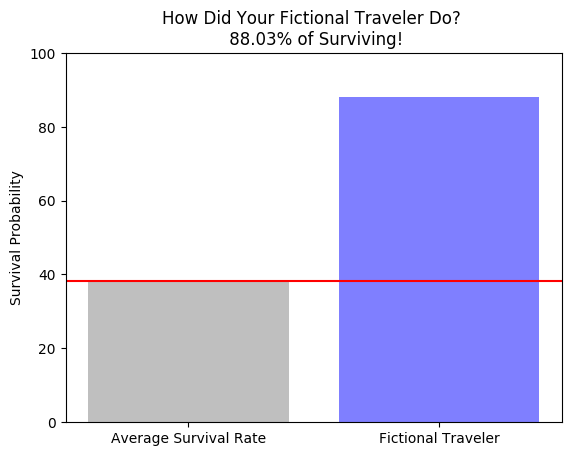

In [106]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
objects = ('Average Survival Rate', 'Fictional Traveler')
y_pos = np.arange(len(objects))
performance = [average_survival_rate, probability_of_surviving_fictional_character]
 
ax = fig.add_subplot(111)
colors = ['gray', 'blue']
plt.bar(y_pos, performance, align='center', color = colors, alpha=0.5)
plt.xticks(y_pos, objects)
plt.axhline(average_survival_rate, color="r")
plt.ylim([0,100])
plt.ylabel('Survival Probability')
plt.title('How Did Your Fictional Traveler Do? \n ' + str(round(probability_of_surviving_fictional_character,2)) + '% of Surviving!')
 
plt.show()